In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import os
import seaborn as sns
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import statsmodels.stats.multitest as ss
from scipy import stats
import matplotlib.gridspec as gs



In [6]:
def calc_rho_pval(summed_count_df, method = 'Bonferroni'):
    out_rho = pd.DataFrame(columns= summed_count_df.columns,index= summed_count_df.columns, )
    out_pval = pd.DataFrame(columns= summed_count_df.columns,index= summed_count_df.columns, )

    for j in summed_count_df.columns:
        for i in summed_count_df.columns:
            dd = summed_count_df[[i,j]].dropna()
            rho, pval =stats.spearmanr(dd[i], dd[j])
            if i==j:
                out_rho.loc[i, j] = 1
                out_pval.loc[i, j] = 0
            else:
                out_rho.loc[i, j] = rho;
                out_pval.loc[i,j] = pval;
#         out_rho.columns = test_corr_pval.columns
#         out_rho.index = test_corr_pval.columns
#         out_pval.columns = test_corr_pval.columns
#         out_pval.index = test_corr_pval.columns
#         out_bonfe=pd.DataFrame(columns = test_corr_pval.columns, index = test_corr_pval.columns)
#         out_bool=pd.DataFrame(columns = test_corr_pval.columns, index = test_corr_pval.columns)

#         for column in out_pval.columns:
#             a, b,c,d = ss.multipletests(out_pval[column], method='bonferroni')
#             out_bonfe[column] = b
#             out_bool[column] = a
    out_bonfe = pd.DataFrame(out_pval.unstack())
    a, b ,c, d = ss.multipletests(pd.DataFrame(out_pval.unstack())[0], method=method)
    out_bonfe[0]=b
    out_bonfe = out_bonfe.reset_index().pivot(columns='level_0', index='level_1', values=0)
    return(out_rho, out_pval, out_bonfe)

def cluster_map_bonfe(rhodf, pvaldf, figname='figures/cluster.pdf',
                      cutoff=0.05, col_colors=None, row_colors=None, symbol='*', vmin=-1, vmax=1):
    cluster = sns.clustermap(rhodf.fillna(0), col_colors=col_colors, row_colors=row_colors,yticklabels=1, 
                         metric='braycurtis',
                 vmin=vmin, vmax=vmax, cmap=sns.color_palette("icefire", as_cmap=True),
                  xticklabels =1,)
    posx_dict={}
    for i in np.array(cluster.ax_heatmap.get_xticklabels()):
        posx_dict[i.get_text()] = i.get_position()[0]
    posy_dict={}
    for i in np.array(cluster.ax_heatmap.get_yticklabels()):
        posy_dict[i.get_text()] = i.get_position()[1]

    sig_map = pvaldf<cutoff
    sig_map.index = sig_map.index.map(posy_dict)
    sig_map.columns = sig_map.columns.map(posx_dict)
    x =[]
    y = []
    for i in sig_map.index:
        for c in sig_map.columns:
            if sig_map.loc[i,c]==True:
                x.append(c)
                y.append(i)
    ax = cluster.ax_heatmap
    ax.scatter(x,y, marker=symbol, color='white', s=2)

    plt.savefig(figname)

In [7]:


#Read in MAG data
HQ_Mags = test = pd.read_csv('../data/taxonomy_color_ranges.csv', index_col=0)
EukMAGDF = pd.read_csv('../tables/final/TableS2_EukaryoticMAG.csv', index_col=0)
translation_dict = pd.read_csv('../rename/renamed-eukaryotic-mags.tsv', sep='\t', index_col=0).to_dict()['new_mag_name']
translation_dict_r = pd.read_csv('../rename/renamed-eukaryotic-mags.tsv', sep='\t', index_col=1).to_dict()['old_mag_name']
HQ_Mags.index = HQ_Mags.index.map(translation_dict)
mmseqs_tax = pd.read_csv('../data/mmseqs-taxonomy.tsv', sep='\t', index_col=0)
mmseqs_tax.index = mmseqs_tax.index.map(translation_dict)
EukMAGDF['total_length_Mb'] = EukMAGDF.total_length/10**6

# Define broad plotting groups of taxa 
fungi_int = mmseqs_tax[mmseqs_tax.kingdom=='Fungi'].index
sar = mmseqs_tax[pd.DataFrame(mmseqs_tax[['kingdom','clade','phylum','class']]==('.','Sar','.', '.')).all(axis=1)].index
EukMAGDF['groups']=EukMAGDF.taxonomy.str.split(';').str[1:3].str.join(';')
EukMAGDF['groups'].unique()
EukMAGDF.loc[fungi_int, 'groups']='Fungi'
EukMAGDF.loc[sar, 'groups'] = 'SAR'
EukMAGDF['groups_full'] =EukMAGDF.groups
EukMAGDF.loc[EukMAGDF['groups']=='Metazoa;Arthropoda', 'groups']='Metazoa'
EukMAGDF.loc[EukMAGDF['groups']=='Metazoa;Cnidaria', 'groups']='Metazoa'
EukMAGDF.loc[EukMAGDF['groups']=='Metazoa;-', 'groups']='Metazoa'
EukMAGDF.loc[EukMAGDF['groups']=='Metazoa;Chordata', 'groups']='Metazoa'
EukMAGDF.loc[EukMAGDF['groups']=='Metazoa;Mollusca', 'groups']='Metazoa'
EukMAGDF.loc[EukMAGDF['groups']=='Archaeplastida;Chlorophyta', 'groups']='Chlorophyta'
EukMAGDF.loc[EukMAGDF['groups']=='Alveolata;Ciliophora', 'groups']='SAR'
EukMAGDF.loc[EukMAGDF['groups']=='Alveolata;Dinoflagellata', 'groups']='SAR'
EukMAGDF.loc[EukMAGDF['groups']=='Alveolata;Ciliophora', 'groups']='SAR'
EukMAGDF.loc[EukMAGDF['groups']=='Stramenopiles;-', 'groups']='SAR'
EukMAGDF.loc[EukMAGDF['groups']=='Amoebozoa;-', 'groups']='Amoebozoa'
EukMAGDF.loc[EukMAGDF['groups']=='-;-', 'groups']='Eukaryota'
EukMAGDF.loc[EukMAGDF['groups']=='Hacrobia;Haptophyta', 'groups']='Haptophyta'
EukMAGDF.loc[EukMAGDF['groups']=='Hacrobia;Cryptophyta', 'groups']='Cryptophyta'
EukMAGDF.loc[EukMAGDF['groups']=='Stramenopiles;Ochrophyta', 'groups']='Orchrophyta'

#Read in the high-quality eukaryotic MAGs
EukMAGDF_HQ = EukMAGDF.merge(HQ_Mags, left_index=True, right_index=True)

#Define color maps
cdict = EukMAGDF_HQ.groupby(['groups', 'color']).count()['name'].reset_index().groupby('groups').max()['color'].to_dict()
cdict['Amoebozoa']='#E66B92'

het_col = {'Phototroph':'#b4cc3d', 'Heterotroph':'#cc3d6d'}
EukMAGDF['color'] = EukMAGDF.groups.map(cdict)

#Read in the trophic data
trophy_df = pd.read_csv('../data/trophy_data.csv', index_col=0)
trophy_df.index = trophy_df.index.map(translation_dict)
trophy_df = trophy_df.merge(EukMAGDF_HQ['groups'], left_index=True, right_index=True)

#read in metagenomic abundance
tpm_df = pd.read_csv('../data/MAG_tpm.csv', index_col=0)
tpm_df.index = tpm_df.index.map(translation_dict)
tpm_df = tpm_df.loc[EukMAGDF_HQ.index]

#Read in pangea data
pangea = pd.read_csv('../data/TARA_sample_enviro.tab', sep ='\t', header=2508, index_col=0)
ena_table = pd.read_csv('../data/PRJEB4352_metaG.txt', sep='\t')
ena_data = ena_table.merge(pangea, left_on='sample_alias', right_index=True) 
ena_data = ena_data.set_index('run_accession')
errdf = pd.read_csv('../data/SampleList_2020_metaG.txt', sep='\t')
errnewdf = pd.DataFrame(columns=errdf.columns)
for i in errdf.index:
    E = errdf.loc[i, 'ERR_list'].split(', ')
    for e in E:
        if e in errnewdf.index:
            pass
        else:
            errnewdf.loc[e]=errdf.loc[i]
errnewdf['depth'] = errnewdf.Depth_sizefrac.str.split('-').str[0]
errnewdf['sf'] = errnewdf.Depth_sizefrac.str.split('-').str[1:].str.join('-')



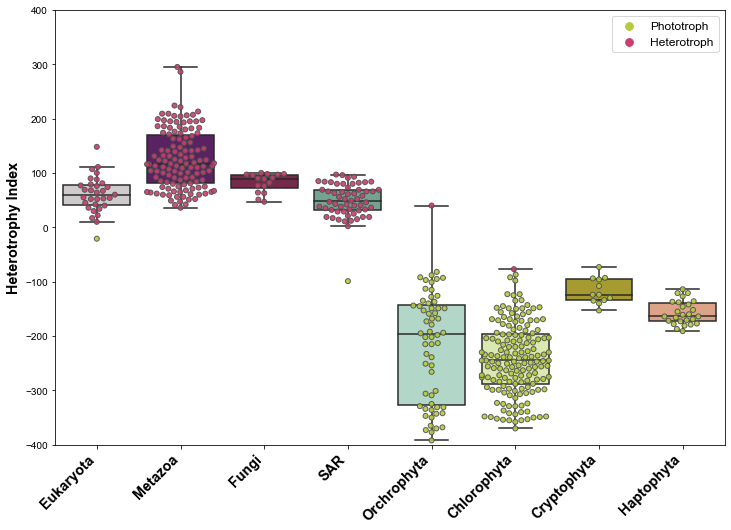

In [8]:
order = ['Eukaryota',  'Metazoa','Fungi','SAR', 'Orchrophyta','Chlorophyta', 'Cryptophyta',  'Haptophyta', ]
flierprops = {'marker':'o', 'alpha':0.5, 'markersize':0}

fig, ax = plt.subplots(1, figsize=[12,8])

sns.boxplot(data = trophy_df, x='groups', y='HeterotrophyScore', palette=cdict,
            ax=ax,order=order, flierprops=flierprops, )
sns.swarmplot(data = trophy_df, x='groups', y='HeterotrophyScore',
             ax=ax, order=order, size=5, hue='PredictedTrophicMode', 
              palette=het_col, alpha=0.9, linewidth=1, edgecolor='gray')
ax.set_ylabel('Heterotrophy Index', fontsize='x-large', fontweight = 'bold')
ax.set_xlabel('')
ax.set_xticklabels(order, rotation=45, ha='right', fontsize='x-large', fontweight='bold')
ax.legend(fontsize='large')
ax.set_ylim([-400, 400])
plt.savefig('../figures/trophy-group_cluster.pdf')

In [9]:
trophy_tpm_merged = trophy_df.merge(tpm_df, left_index=True, right_index=True)
trophy_tpm_merged = trophy_tpm_merged.groupby('PredictedTrophicMode').sum()[tpm_df.columns].T
trophy_tpm_merged = trophy_tpm_merged.merge(ena_data, left_index=True, right_index=True)
trophy_tpm_merged = trophy_tpm_merged.merge(errnewdf, left_index=True, right_index=True)


In [10]:
cols = [ 'Heterotroph','Phototroph',
 'Depth ref [m] (in the selected environmental...)',
 'Sal (in the selected environmental...)',
 'Tpot [°C] (in the selected environmental...)',
 'Sigma-theta [kg/m**3] (in the selected environmental...)',
 'O2 [µmol/kg] (in the selected environmental...)',
 '[NO3]- [µmol/l] (in the selected environmental...)',
 '[NO2]- [µmol/l] (in the selected environmental...)',
 '[PO4]3- [µmol/l] (in the selected environmental...)',
 '[NO3]- + [NO2]- [µmol/l] (in the selected environmental...)',
 'Si(OH)4 [µmol/l] (in the selected environmental...)',
 'Chl a [mg/m**3] (in the selected environmental...)',
 'bbp470 [1/m] (in the selected environmental...)',
 'fCDOM [ppb (QSE)] (in the selected environmental...)',
 'bacp660 [1/m] (in the selected environmental...)',
 'fCDOM [ppb (QSE)] (at the sampling location, exp...)',
 'PAR day [mol quanta/m**2/day] (for a period of 8 days around...)',
 'NPP C [mg/m**2/day] (for a period of 8 days around...)',
 'MLD [m] (in the selected environmental...)',
 'D chl m [m] (in the selected environmental...)',
 'Depth max Brunt Väisälä freq [m] (in the selected environmental...)',
 'Depth max O2 [m] (in the selected environmental...)',
 'Depth nitracline [m] (in the selected environmental...)',
 'SSD [min] (day length)',
 "u [cm/s] (Calculated (d'Ovidio et al. 2...)",
 "v [cm/s] (Calculated (d'Ovidio et al. 2...)",
 'OW (indicates the presence of an ...)',
 'MLE [1/day] (indicates the presence of a t...)',
 "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)",
 'RT [days] (of the water mass. Values>30 ...)',
]

In [11]:
def draw_pie(dist, 
             xpos, 
             ypos, 
             size, cartopy=True,
             ax=None, colors=['blue', 'red'], alpha=0.8):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))

    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()
    if cartopy:
        for r1, r2, c in zip(pie[:-1], pie[1:], colors):
            angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
            x = [0] + np.cos(angles).tolist()
            y = [0] + np.sin(angles).tolist()

            xy = np.column_stack([x, y])

            ax.scatter([xpos], [ypos], marker=xy, s=size, transform=ccrs.PlateCarree(), color=c, alpha=alpha)
    else:
        for r1, r2 in zip(pie[:-1], pie[1:]):
            angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
            x = [0] + np.cos(angles).tolist()
            y = [0] + np.sin(angles).tolist()

            xy = np.column_stack([x, y])

            ax.scatter([xpos], [ypos], marker=xy, s=size,)

    return ax
def plot_maps_overlay_sf(df, scale = 10e-4, ax=None, depth = 'SRF'):
    sf = ['0.8-5.00','5-20.00', '20-180.00','180-2000.00', ]
    fig = plt.figure(figsize=(18, 18))
    gs = fig.add_gridspec(1, 4)

    for i, s in enumerate(sf):
        sdf = df[(df['sf']==s) & (df['depth']==depth)]
        ax = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND, color = 'gray')
        
        for i in sdf.index:
            draw_pie([sdf.loc[i,'Heterotroph'],sdf.loc[i,'Phototroph']], 
                     xpos =sdf.loc[i,'Longitude'], ypos=sdf.loc[i,'Latitude'],
                     size=sdf.loc[i,['Heterotroph', 'Phototroph']].sum()*scale, cartopy=True, ax=ax, 
                     colors=[het_col['Heterotroph'], het_col['Phototroph']])
        ax.set_title(s, fontsize='x-large', fontweight='bold')
        ax.set_extent([-180, 110, -80, 70], crs=ccrs.PlateCarree())
    legend_sizes = [1e4,5e4, 1e5,5e5]
    for i in legend_sizes:
        ax.scatter(x=0, y=0, s=i*scale, label='{:1.0e}'.format(i), color='red', lw=0)
    ax.legend(scatterpoints=1, loc=[1.2,0], ncol=1)
#         ax.scatter(x =df.Longitude, y=df.Latitude, 
#                s= df[c]*scale, transform=ccrs.PlateCarree(), alpha=0.5,color=het_col[c])
    

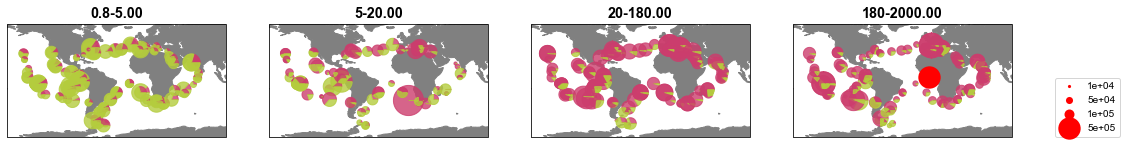

In [12]:
plot_maps_overlay_sf(trophy_tpm_merged, depth='SRF')
plt.savefig('../figures/SRF-het-prot-map.pdf')

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


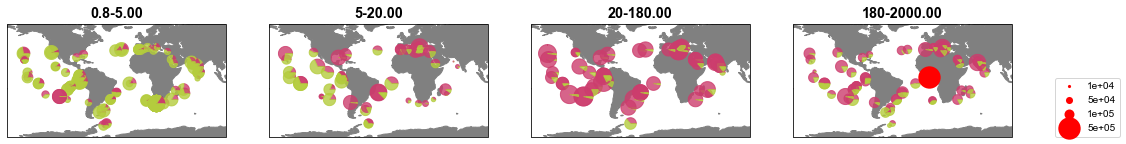

In [13]:
plot_maps_overlay_sf(trophy_tpm_merged, depth='DCM')
plt.savefig('../figures/DCM-het-prot-map.pdf')

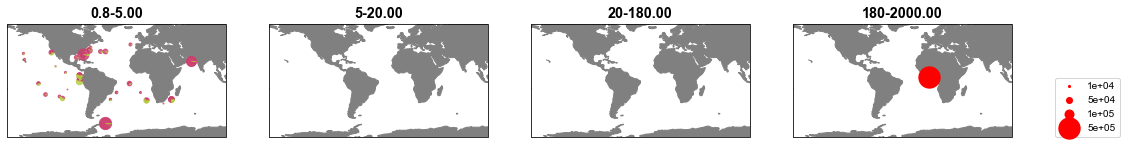

In [14]:
plot_maps_overlay_sf(trophy_tpm_merged, depth='MES')
plt.savefig('../figures/MES-het-prot-map.pdf')

In [15]:
out_rho, out_pval, out_bonfe = calc_rho_pval(trophy_tpm_merged[cols])


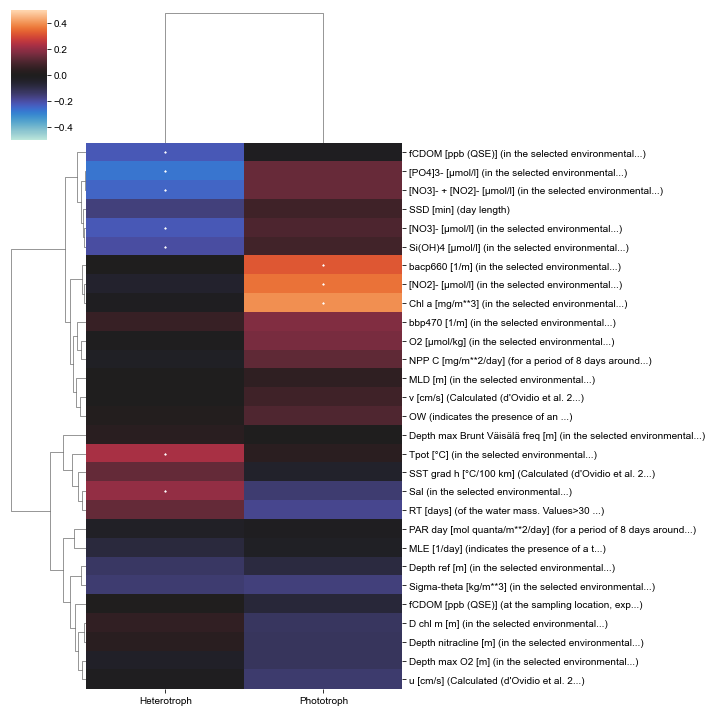

In [16]:
i = ['Heterotroph','Phototroph']
cluster_map_bonfe(out_rho.fillna(0)[i].drop(i), out_bonfe.fillna(1)[i].drop(i), figname='../figures/trophy-env-cluste.pdf', cutoff=0.001
                 , vmin=-.5, vmax=.5)

In [21]:
pangea[['Env feature (full name (ENVO:ID), terms re...)','RT [days] (of the water mass. Values>30 ...)']].dropna()

,"Env feature (full name (ENVO:ID), terms re...)",RT [days] (of the water mass. Values>30 ...)
Sample ID (TARA_barcode#),,
TARA_X000000180,surface water layer (ENVO:00002042),22.43
TARA_X000000181,surface water layer (ENVO:00002042),22.43
TARA_X000000182,surface water layer (ENVO:00002042),22.43
TARA_X000000183,surface water layer (ENVO:00002042),22.43
TARA_X000000184,surface water layer (ENVO:00002042),22.43
...,...,...
TARA_Y100000464,mesopelagic zone (ENVO:00000213),25.95
TARA_Y100000465,mesopelagic zone (ENVO:00000213),25.95
TARA_Y100000466,mesopelagic zone (ENVO:00000213),25.95
